In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [2]:
#this function is used to plot figs in plotly

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [3]:
data_2020 = pd.read_csv('drive/MyDrive/Colab Notebooks/data/2020.csv')

In [4]:
data_2020.head()

,Time (CET),Actual Total Load [MW]
0,01.01.2020 00:00 - 01.01.2020 00:15,4374
1,01.01.2020 00:15 - 01.01.2020 00:30,4324
2,01.01.2020 00:30 - 01.01.2020 00:45,4284
3,01.01.2020 00:45 - 01.01.2020 01:00,4220
4,01.01.2020 01:00 - 01.01.2020 01:15,4173


In [185]:
data_2020.tail()

,Time (CET),Actual Total Load [MW]
35135,31.12.2020 22:45 - 31.12.2020 23:00,4441
35136,31.12.2020 23:00 - 31.12.2020 23:15,4415
35137,31.12.2020 23:15 - 31.12.2020 23:30,4358
35138,31.12.2020 23:30 - 31.12.2020 23:45,4378
35139,31.12.2020 23:45 - 01.01.2021 00:00,4356


Some info about 2015 demand data


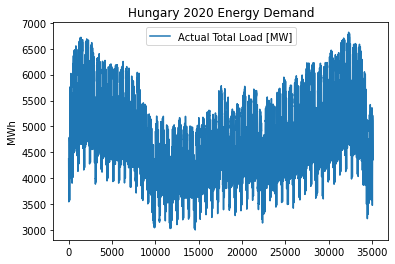

,Actual Total Load [MW]
count,35140.000000
mean,4884.528002
std,779.227408
min,2998.000000
25%,4307.000000
50%,4859.000000
75%,5432.000000
max,6820.000000


In [186]:
print ("Some info about 2015 demand data")
data_2020.plot(title="Hungary 2020 Energy Demand")
plt.ylabel("MWh")
plt.show()
data_2020.describe()

In [5]:
data_2020 = data_2020.reset_index()
data_2020 = data_2020.drop(columns = "index", axis = 1)

In [6]:
# Removing duplicates
data_2020 = data_2020.drop_duplicates(subset="Time (CET)")

In [7]:
data_2020 = data_2020.drop(columns = "Time (CET)", axis = 1) #remove Time column in data and replacing with meaningful datetime 

In [8]:
data_2020['datetime'] = pd.date_range(start='01-01-2020t00:00', periods=len(data_2020), freq="15min")  #specifying datetime
data_2020 = data_2020[['datetime', 'Actual Total Load [MW]']]

In [9]:
data_2020 = data_2020.set_index('datetime')

In [10]:
data_2020.head()

,Actual Total Load [MW]
datetime,
2020-01-01 00:00:00,4374
2020-01-01 00:15:00,4324
2020-01-01 00:30:00,4284
2020-01-01 00:45:00,4220
2020-01-01 01:00:00,4173


In [195]:
data_2020.tail()

,Actual Total Load [MW]
datetime,
2020-12-31 22:45:00,4441
2020-12-31 23:00:00,4415
2020-12-31 23:15:00,4358
2020-12-31 23:30:00,4378
2020-12-31 23:45:00,4356


Perfect data without missing values


In [11]:
# converting the data from 15 min periods into 1 hour periods
hourly_2020 = data_2020.iloc[0::4, :] # keeping every 4 sample starting from 0

In [12]:
hourly_2020.head(5)

,Actual Total Load [MW]
datetime,
2020-01-01 00:00:00,4374
2020-01-01 01:00:00,4173
2020-01-01 02:00:00,3896
2020-01-01 03:00:00,3671
2020-01-01 04:00:00,3552


In [13]:
# I want three last months of 2020 for this project
forth_quarter= hourly_2020.loc['10/1/2020  12:00:00 AM':'1/1/2021  12:00:00 AM']

In [14]:
#plotting three last months
configure_plotly_browser_state()
dc = go.Scatter(x=forth_quarter.index, y=forth_quarter, name= 'Demand last three months of 2020')
py.iplot([dc])


In [15]:
data = forth_quarter

In [16]:
#Use MinMaxScaler to normalize data to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values = data.values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(values)

In [22]:
data.max(), data.min(), data.mean()

(1.0, 0.0, 0.5597192)

In [23]:
data.shape[0]

2208

In [24]:
# (batch, seq_length=60, features=1)
def make_timeseries_instances(data, seq_length=60):
  # to be done
  X = []
  Y = []
  for start in range(0, data.shape[0]-seq_length):
    X.append(data[start:start+seq_length])
    Y.append(data[start+seq_length])
  X = np.array(X)
  Y = np.array(Y)
  return X, Y

In [25]:
seq_length=60 
X,Y = make_timeseries_instances(data, seq_length=seq_length)
#X = X.reshape(960,40,-1)
#X = np.expand_dims(X,-1)
X = np.atleast_3d(X)
Y = np.expand_dims(Y, axis=-1)
print(X.shape)
print(Y.shape)

(2148, 60, 1)
(2148, 1, 1)


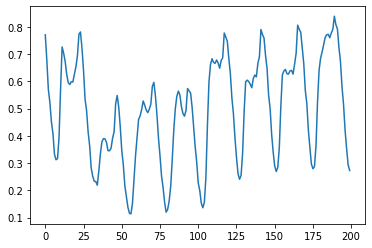

In [209]:
plt.plot(data.reshape(-1)[500:700])

In [26]:
model = Sequential()
model.add(LSTM(16, input_shape=(seq_length, 1)))
model.add(Dense(1, activation='linear'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                   patience=50, verbose=1,
                   restore_best_weights=True)

history = model.fit(X,Y, batch_size=32, validation_split=0.2, callbacks=[es], epochs=50)

Epoch 1/50
54/54 [==============================] - 4s 37ms/step - loss: 0.1097 - mae: 0.2605 - val_loss: 0.0311 - val_mae: 0.1497
Epoch 2/50
54/54 [==============================] - 1s 26ms/step - loss: 0.0286 - mae: 0.1470 - val_loss: 0.0290 - val_mae: 0.1413
Epoch 3/50
54/54 [==============================] - 1s 26ms/step - loss: 0.0253 - mae: 0.1375 - val_loss: 0.0245 - val_mae: 0.1313
Epoch 4/50
54/54 [==============================] - 2s 28ms/step - loss: 0.0218 - mae: 0.1273 - val_loss: 0.0211 - val_mae: 0.1199
Epoch 5/50
54/54 [==============================] - 1s 26ms/step - loss: 0.0178 - mae: 0.1132 - val_loss: 0.0167 - val_mae: 0.1052
Epoch 6/50
54/54 [==============================] - 1s 25ms/step - loss: 0.0138 - mae: 0.0972 - val_loss: 0.0134 - val_mae: 0.0922
Epoch 7/50
54/54 [==============================] - 1s 23ms/step - loss: 0.0103 - mae: 0.0817 - val_loss: 0.0099 - val_mae: 0.0779
Epoch 8/50
54/54 [==============================] - 1s 27ms/step - loss: 0.0086 - m

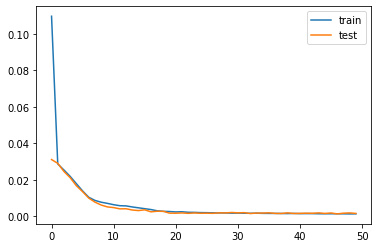

In [30]:
#Plot line graph to show amount loss according the the epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [31]:
preds = model.predict(X)

In [32]:
Y.shape , preds.shape

((2148, 1, 1), (2148, 1))

In [33]:
Y = Y.reshape(2148,1)

In [34]:
#Scaler Inverse Y back to normal value
preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
Y_inv = scaler.inverse_transform(Y.reshape(-1, 1))

In [36]:
#Convert X to dates¶
predictDates = forth_quarter.tail(len(preds_inv)).index

In [42]:
Y_reshape = Y_inv.reshape(len(Y_inv))
pred_reshape = preds_inv.reshape(len(preds_inv))

In [43]:
configure_plotly_browser_state()
actual_chart = go.Scatter(x=predictDates, y=Y_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=pred_reshape, name= 'Predicted Price')
py.iplot([actual_chart, predict_chart])

In [44]:
#RMSE
rmse = sqrt(mean_squared_error(Y_reshape, pred_reshape))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 124.980
